# Text Summarization

Importing necessary libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

from sumy.summarizers.lex_rank import LexRankSummarizer 
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.reduction import ReductionSummarizer

In [2]:
df = pd.read_csv('Reviews.csv', index_col = 'Id')
df.head(2)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


## Data Preprocessing

In [3]:
df.dropna(inplace=True)
# df.isnull().sum()

In [4]:
reviews = pd.DataFrame({
    'Review':df['Text'].values, 
    'Summary':df['Summary'].values})
reviews.head(3)

,Review,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"


In [5]:
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

In [6]:
def clean_text(text, remove_stopwords = True):
    text = text.lower().split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'\.+', ".", text)
    text = re.sub(r'[_"\-;%()|+&=*%,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br>', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [7]:
clean_summaries = []
for summary in reviews['Summary']:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Cleaned summaries")

clean_texts = []
for text in reviews['Review']:
    clean_texts.append(clean_text(text))
print("Cleaned Reviews")

Cleaned summaries
Cleaned Reviews


In [8]:
for i in range(2):
    print("Clean Review #",i+1)
    print(clean_texts[i])
    print("Summary")
    print(clean_summaries[i])
    print()

Clean Review # 1
bought several vitality canned dog food products found good quality. product looks like stew processed meat smells better. labrador finicky appreciates product better most.
Summary
good quality dog food

Clean Review # 2
product arrived labeled jumbo salted peanuts.the peanuts actually small sized unsalted. sure error vendor intended represent product jumbo .
Summary
not as advertised



In [9]:
# trainData = reviews.iloc[:int(len(reviews) * 0.8)]
# testData = reviews.iloc[int(len(reviews) * 0.8):]

# trainX = trainData['Review'].values
# trainy = trainData['Summary'].values
# testX = testData['Review'].values
# testy = testData['Summary'].values

In [9]:
language = 'english'
sentence_count = 1
sw = stopwords.words('english') 

In [10]:
def cosine(X, Y):
    X_list = word_tokenize(X)  
    Y_list = word_tokenize(Y)  
    l1 =[]
    l2 =[] 
    X_set = {w for w in X_list if not w in sw}  
    Y_set = {w for w in Y_list if not w in sw} 
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: 
            l1.append(1)  
        else: 
            l1.append(0) 
        if w in Y_set: 
            l2.append(1) 
        else: 
            l2.append(0)
    c = 0
    for i in range(len(rvector)): 
            c += l1[i] * l2[i] 
    temp = float((sum(l1)*sum(l2))**0.5)
    if float((sum(l1)*sum(l2))**0.5) == 0:
        temp = -float("inf")
    cosine = c / temp
    return round(cosine,3)

## Algorithms

### LexRank

In [11]:
summarizer1 = LexRankSummarizer(Stemmer(language))
summarizer1.stopwords = get_stop_words(language)
lexRankSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser(clean_texts[i], Tokenizer(language))
    lexRankSummary.append(summarizer1(parser.document, sentence_count))

#### Cosine Similarity

In [12]:
lexRankCosine = 0
for i in range(len(clean_summaries)):
    for sentence in lexRankSummary[i]:
        lexRankCosine += cosine(clean_summaries[i], str(sentence))
lexRankCosine = lexRankCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [13]:
lexRankBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in lexRankSummary[i]:
        lexRankBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
lexRankBLEU = lexRankBLEU/len(clean_summaries)
lexRankBLEU = round(lexRankBLEU,3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [14]:
lexRankRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in lexRankSummary[i]:
        lexRankRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
lexRankRouge = lexRankRouge / len(clean_summaries)
lexRankRouge = round(lexRankRouge,3)

### Luhn

In [15]:
summarizer2 = LuhnSummarizer(Stemmer(language))
summarizer2.stop_words = get_stop_words(language)
luhnSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    luhnSummary.append(summarizer2(parser.document, sentence_count))

#### Cosine Similarity

In [16]:
luhnCosine = 0
for i in range(len(clean_summaries)):
    for sentence in luhnSummary[i]:
        luhnCosine += cosine(clean_summaries[i], str(sentence))
luhnCosine = luhnCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [17]:
luhnBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in luhnSummary[i]:
        luhnBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
luhnBLEU = luhnBLEU / len(clean_summaries)
luhnBLEU = round(luhnBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [18]:
luhnRouge = 0
for i in range(len(clean_summaries)):
    for sentence in luhnSummary[i]:
        luhnRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
luhnRouge = luhnRouge / len(clean_summaries)
luhnRouge = round(luhnRouge, 3)

### LSA

In [19]:
summarizer3 = LsaSummarizer(Stemmer(language))
summarizer3.stop_words = get_stop_words(language)
lsaSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    lsaSummary.append(summarizer3(parser.document, sentence_count))

#### Cosine Similarity

In [20]:
lsaCosine = 0
for i in range(len(clean_summaries)):
    for sentence in lsaSummary[i]:
        lsaCosine += cosine(clean_summaries[i], str(sentence))
lsaCosine = lsaCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [21]:
lsaBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in lsaSummary[i]:
        lsaBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
lsaBLEU = lsaBLEU / len(clean_summaries)
lsaBLEU = round(lsaBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [44]:
lsaRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in lsaSummary[i]:
        lsaRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
lsaRouge = lsaRouge / len(clean_summaries)
lsaRouge = round(lsaRouge, 3)

### TextRank

In [23]:
summarizer4 = TextRankSummarizer(Stemmer(language))
summarizer4.stop_words = get_stop_words(language)
textRankSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    textRankSummary.append(summarizer4(parser.document, sentence_count))

#### Cosine Similarity

In [24]:
textRankCosine = 0
for i in range(len(clean_summaries)):
    for sentence in textRankSummary[i]:
        textRankCosine += cosine(clean_summaries[i], str(sentence))
textRankCosine = textRankCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [25]:
textRankBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in textRankSummary[i]:
        textRankBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
textRankBLEU = textRankBLEU / len(clean_summaries)
textRankBLEU = round(textRankBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [26]:
textRankRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in textRankSummary[i]:
        lsaRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
textRankRouge = textRankRouge / len(clean_summaries)
textRankRouge = round(textRankRouge, 3)

## Edmundson

In [27]:
summarizer5 = EdmundsonSummarizer(Stemmer(language))
summarizer5.stop_words = get_stop_words(language)
edmundsonSummary = []
for i in range(len(clean_texts)):
    summarizer5.bonus_words = ['good'] + clean_texts[i].split()
    summarizer5.stigma_words = ['bad', 'worst']
    summarizer5.null_words = ['zdfgthdvndadv']
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    edmundsonSummary.append(summarizer5(parser.document, sentence_count))

#### Cosine Similarity

In [28]:
edmundsonCosine = 0
for i in range(len(clean_summaries)):
    for sentence in edmundsonSummary[i]:
        edmundsonCosine += cosine(clean_summaries[i], str(sentence))
edmundsonCosine = edmundsonCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [29]:
edmundsonBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in edmundsonSummary[i]:
        edmundsonBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
edmundsonBLEU = edmundsonBLEU / len(clean_summaries)
edmundsonBLEU = round(edmundsonBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [30]:
edmundsonRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in edmundsonSummary[i]:
        edmundsonRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
edmundsonRouge = edmundsonRouge / len(clean_summaries)
edmundsonRouge = round(edmundsonRouge, 3)

### SumBasic

In [31]:
summarizer6 = SumBasicSummarizer(Stemmer(language))
summarizer6.stop_words = get_stop_words(language)
sumBasicSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    sumBasicSummary.append(summarizer6(parser.document, sentence_count))

#### Cosine Similarity

In [32]:
sumBasicCosine = 0
for i in range(len(clean_summaries)):
    for sentence in sumBasicSummary[i]:
        sumBasicCosine += cosine(clean_summaries[i], str(sentence))
sumBasicCosine = sumBasicCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [33]:
sumBasicBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in sumBasicSummary[i]:
        sumBasicBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
sumBasicBLEU = sumBasicBLEU / len(clean_summaries)
sumBasicBLEU = round(sumBasicBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [34]:
sumBasicRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in sumBasicSummary[i]:
        sumBasicRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
sumBasicRouge = sumBasicRouge / len(clean_summaries)
sumBasicRouge = round(sumBasicRouge, 3)

### KL

In [35]:
summarizer7 = KLSummarizer(Stemmer(language))
summarizer7.stop_words = get_stop_words(language)
klSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    klSummary.append(summarizer7(parser.document, sentence_count))

#### Cosine Similarity

In [36]:
klCosine = 0
for i in range(len(clean_summaries)):
    for sentence in klSummary[i]:
        klCosine += cosine(clean_summaries[i], str(sentence))
klCosine = klCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [37]:
klBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in klSummary[i]:
        klBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
klBLEU = klBLEU / len(clean_summaries)
klBLEU = round(klBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [38]:
klRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in klSummary[i]:
        klRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
klRouge = klRouge / len(clean_summaries)
klRouge = round(klRouge, 3)

### Reduction Summarizer

In [39]:
summarizer8 = KLSummarizer(Stemmer(language))
summarizer8.stop_words = get_stop_words(language)
reductionSummary = []
for i in range(len(clean_texts)):
    parser = PlaintextParser.from_string(clean_texts[i], Tokenizer(language))
    reductionSummary.append(summarizer8(parser.document, sentence_count))

#### Cosine Similarity

In [40]:
reductionCosine = 0
for i in range(len(clean_summaries)):
    for sentence in reductionSummary[i]:
        reductionCosine += cosine(clean_summaries[i], str(sentence))
reductionCosine = reductionCosine/len(clean_summaries)

#### Bilingual Evaluation Understudy Score (BLEU)

In [41]:
reductionBLEU = 0
for i in range(len(clean_summaries)):
    for sentence in reductionSummary[i]:
        reductionBLEU += sentence_bleu([word_tokenize(clean_summaries[i])], word_tokenize(str(sentence)), 
                                    smoothing_function=SmoothingFunction().method4)
reductionBLEU = reductionBLEU / len(clean_summaries)
reductionBLEU = round(reductionBLEU, 3)

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE-L)

In [42]:
reductionRouge = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(clean_summaries)):
    for sentence in reductionSummary[i]:
        reductionRouge += scorer.score(clean_summaries[i], str(sentence))['rougeL'][1]
reductionRouge = reductionRouge / len(clean_summaries)
reductionRouge = round(reductionRouge, 3)

## Comparative Analysis

In [45]:
metric = pd.DataFrame({
    'Algorithms': ['LexRank', 'Luhn', 'LSA', 'TextRank', 'Edmundson', 'Sum Basic', 'KL', 'Reduction'],
    'Cosine similarity': [lexRankCosine, luhnCosine, lsaCosine, textRankCosine, edmundsonCosine, sumBasicCosine, klCosine, reductionCosine],
    'BLEU (Precision)': [lexRankBLEU, luhnBLEU, lsaBLEU, textRankBLEU, edmundsonBLEU, sumBasicBLEU, klBLEU, reductionBLEU],
    'Rouge (Recall)': [lexRankRouge, luhnRouge, lsaRouge, textRankRouge, edmundsonRouge, sumBasicRouge, klRouge, reductionRouge],

}, index=range(1,9))
metric

,Algorithms,Cosine similarity,BLEU (Precision),Rouge (Recall)
1,LexRank,0.2934,0.586,0.346
2,Luhn,0.2902,0.573,0.346
3,LSA,0.1863,0.534,0.229
4,TextRank,0.2180,0.482,0.000
5,Edmundson,0.1847,0.222,0.246
6,Sum Basic,0.1276,0.385,0.183
7,KL,0.1742,0.586,0.196
8,Reduction,0.1742,0.586,0.196


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

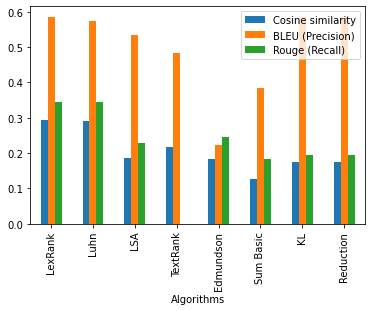

In [46]:
metric.plot(x='Algorithms', kind='bar')
plt.xticks(rotation=90)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

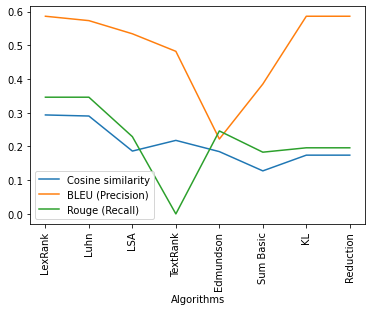

In [47]:
metric.plot(x='Algorithms', kind='line')
plt.xticks(rotation=90)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

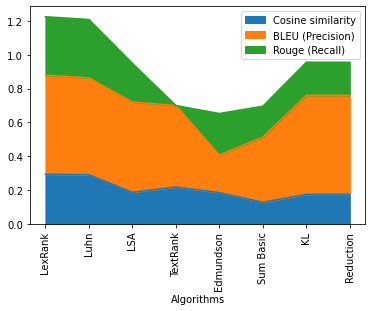

In [48]:
metric.plot(x='Algorithms', kind='area')
plt.xticks(rotation=90)

In [49]:
metric.to_csv('result.csv',index=False)